In [1]:
# HPC deployment
SPARK_MASTER = 'spark://cs445:64818'
FILE_DIR = '/scratch/si2073/output'
TARGET_PATH = '/scratch/tmv7269/datasets/'
EXAMPLE_FILE = FILE_DIR + '/enwiki-20230401-pages-meta-history10.xml-p4045403p4096288.csv'

In [2]:
from pyspark.sql.functions import explode, collect_list, udf, count, first, col, array, sum
from pyspark.sql.types import StructType, StructField, ArrayType, StringType
import pandas as pd
import numpy as np

In [3]:
import re
import datasets
import os
from pathlib import Path
from huggingface_hub import snapshot_download

os.environ["HF_HOME"] = TARGET_PATH
os.environ["HF_DATASETS_CACHE"] = TARGET_PATH

In [4]:
snapshot_download(repo_id="Cohere/wikipedia-22-12-en-embeddings", 
                  local_dir=TARGET_PATH,
                  cache_dir=TARGET_PATH,
                  repo_type="dataset")

Fetching 256 files:   0%|          | 0/256 [00:00<?, ?it/s]

'/scratch/tmv7269/datasets'

# Construct the Spark rdd for documents embedding

In [5]:
# setting up spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
import pyspark

spark = SparkSession.builder.master(SPARK_MASTER) \
                            .config('spark.executor.memory', '4G') \
                            .config('spark.driver.memory', '60G') \
                            .config("spark.memory.offHeap.enabled", True) \
                            .config("spark.memory.offHeap.size","16g") \
                            .appName('ProcessData') \
                            .getOrCreate()
spark.sparkContext.setLogLevel("Off")
spark

23/05/08 00:04:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
# Load Cohere's full dataset
drop_columns = ['text', 'id', 'url', 'title', 'langs', 'paragraph_id', 'views']
id_emb_map = spark.read.parquet(f"{TARGET_PATH}/data").drop(*drop_columns).drop_duplicates(subset=['wiki_id'])
id_emb_map.show()

+-------+--------------------+
|wiki_id|                 emb|
+-------+--------------------+
|   1088|[0.24366963, -0.6...|
|   1580|[0.0684566, 0.260...|
|   1645|[0.3224766, 0.458...|
|   2122|[0.111770935, 0.4...|
|   2866|[-0.2080042, -0.2...|
|   3175|[0.16152096, 0.30...|
|   3794|[0.051881086, 0.4...|
|   3997|[0.27129447, 0.53...|
|   4101|[0.34501484, -0.1...|
|   4519|[0.33576313, 0.24...|
|   5300|[0.3257199, -0.34...|
|   6336|[0.38157865, 0.15...|
|   6357|[0.39418507, -0.2...|
|   6466|[-0.1551857, 1.00...|
|   6620|[0.12537971, 0.51...|
|   6654|[-0.105314195, 0....|
|   7253|[0.25702828, 0.55...|
|   7554|[0.2620884, 0.488...|
|   7833|[0.24061485, 0.41...|
|   8086|[0.3114842, -0.26...|
+-------+--------------------+
only showing top 20 rows



In [7]:
id_emb_map.count()

5745033

# Reading in editors csv

In [8]:
def lst_to_str(x):
    return re.sub(r'[^ \w+]', '', x).split()

columns = ['title', 'text', 'username', 'article_id']
df = pd.read_csv(EXAMPLE_FILE, names=columns, skiprows=1).drop(columns='text')
df['username'] = df.username.apply(lst_to_str)

In [9]:
df.count()

title         30246
username      30246
article_id    30246
dtype: int64

In [10]:
spark_df = spark.createDataFrame(df)

In [11]:
spark_df.head()

Row(title='Foster Air Force Base', username=['Dirtydan667', 'Dirtydan667', 'RussBot', 'Ktr101', 'Ktr101', 'Ktr101', 'Ktr101', 'Ndunruh', 'PigFlu', 'Oink', 'Bwmoll3', 'LilHelpa', 'ColoBill4', 'ColoBill4', 'Ground', 'Zero', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Vanished', 'user', '31415926535897932384626433', 'Firsfron', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'Bwmoll3', 'DiiCinta', 'Bwmoll3', 'Bwmoll3', 'Backspace', 'Rich', 'Farmbrough', 'Mark', 'Sublette', 'Mark', 'Sublette', 'Mark', 'Sublette', 'Kumioko', 'renamed', 'Ulric1313', 'Mark', 'Sublette', 'Ulric1313', 'Mark', 'Sublette', 'Lightmouse', 'Gcstackmone

In [12]:
from pyspark.sql.functions import explode, collect_list, count, udf, avg
from pyspark.sql.types import DoubleType
from collections import Counter

exploded = spark_df.select(spark_df.article_id, explode(spark_df.username).alias('username'))
collapsed = exploded.groupBy("username", "article_id").agg(count("article_id").alias('count'))
collapsed = collapsed.join(id_emb_map,collapsed.article_id ==  id_emb_map.wiki_id,"inner")
collapsed = collapsed.drop('article_id', 'wiki_id')
collapsed.show()

+---------------+-----+--------------------+
|       username|count|                 emb|
+---------------+-----+--------------------+
|TheRedPenOfDoom|    2|[-0.159246, 0.024...|
|      Waacstats|    1|[-0.159246, 0.024...|
|           Saji|    1|[-0.159246, 0.024...|
|      KasparBot|    1|[-0.159246, 0.024...|
|       Kathanar|    2|[-0.159246, 0.024...|
|    Shyamsunder|    3|[-0.159246, 0.024...|
|        Hockett|    1|[-0.159246, 0.024...|
|       PrimeBOT|    1|[-0.159246, 0.024...|
|Pancakeslover11|    1|[-0.159246, 0.024...|
|             NG|    1|[-0.159246, 0.024...|
|         Srivin|    1|[-0.159246, 0.024...|
|        Pkbwcgs|    1|[-0.159246, 0.024...|
|          Tachs|    3|[-0.159246, 0.024...|
|            bot|    5|[-0.159246, 0.024...|
|     KolbertBot|    1|[-0.159246, 0.024...|
|      TomReding|    1|[-0.159246, 0.024...|
|       Citation|    1|[-0.159246, 0.024...|
|        Auntof6|    1|[-0.159246, 0.024...|
|        Bluebot|    1|[-0.159246, 0.024...|
|       Ro

In [13]:
editors_collapsed = collapsed.groupby('username').agg(collect_list('emb').alias('embs'), collect_list('count').alias('counts'))
editors_collapsed.show()

+-------------+--------------------+--------------------+
|     username|                embs|              counts|
+-------------+--------------------+--------------------+
|           07|[[-0.36483073, 0....|[2, 1, 3, 2, 1, 1...|
| 11deadpool11|[[0.18078326, 0.2...|                 [1]|
|      4meter4|[[-0.027774015, 0...|[1, 1, 3, 1, 1, 2...|
|      4owowoo|[[0.6785187, -0.1...|                 [1]|
|    A1octopus|[[0.08518514, 0.2...|                 [2]|
|          Aa4|[[0.04368933, -0....|                 [2]|
|AaronzAccount|[[0.049395856, 0....|                 [3]|
|          Ahc|[[0.19575398, 0.1...|                 [1]|
|      Ahendra|[[0.10124794, 0.1...|[4, 1, 4, 6, 188,...|
|Ajaydhivyanth|[[0.07035242, -0....|                 [1]|
|         Ales|[[-0.037420806, 0...|                 [2]|
|   Algebraist|[[0.14202555, 0.2...|           [1, 1, 1]|
|     Alienpmk|[[0.30616087, -0....|                 [3]|
|      Amazing|[[0.20678379, -0....|              [1, 1]|
|Amershakigaga

In [16]:
from typing import List, Tuple
import numpy as np
import math
import itertools

# each editor has a list of ([emb], count) of the things they edited
# assuming all id in list is unique
def calculate_editor_variance(matrix : List[List[int]], weights : List[int]):
    return float(calculate_multid_distance(matrix, weights))

"""
Take in matrix of article x embedding and article's respective weight, return their variance in k-dimension
this is easier to interpret when using LDA (since you can see how far editors stray on certain topic, 
    assuming topic itself is indepedent)
With vaguer embedding, it's better to use the L2 norm and compress it to a single number
"""
def calculate_multid_variance(matrix, weights):
    average = np.average(matrix, weights=weights, axis=0)
    variance = np.average((matrix-average)**2, weights=weights, axis=0)
    return np.sqrt(variance)

"""
Calculate L2 distance for each d-dimension point
"""
def calculate_multid_distance(matrix, weights):
    average = np.average(matrix, weights=weights, axis=0)
    l2 = np.linalg.norm(matrix-average, axis=1)
    return np.average(l2)

In [58]:
calc_variance_udf = udf(calculate_editor_variance, DoubleType())
editors_variance = editors_collapsed.withColumn('variance', calc_variance_udf(editors_collapsed.embs, editors_collapsed.counts))
editors_variance.show()

+-------------+--------------------+--------------------+------------------+
|     username|                embs|              counts|          variance|
+-------------+--------------------+--------------------+------------------+
|           07|[[0.4635992, 0.46...|[2, 3, 1, 1, 1, 2...| 7.138805817490526|
| 11deadpool11|[[0.18078326, 0.2...|                 [1]|               0.0|
|      4meter4|[[0.39415038, 0.4...|[1, 2, 3, 1, 1, 1...| 6.580253111103204|
|      4owowoo|[[0.6785187, -0.1...|                 [1]|               0.0|
|    A1octopus|[[0.08518514, 0.2...|                 [2]|               0.0|
|          Aa4|[[0.04368933, -0....|                 [2]|               0.0|
|AaronzAccount|[[0.049395856, 0....|                 [3]|               0.0|
|          Ahc|[[0.19575398, 0.1...|                 [1]|               0.0|
|      Ahendra|[[0.0662515, -0.3...|[188, 4, 6, 119, ...| 6.059694284573164|
|Ajaydhivyanth|[[0.07035242, -0....|                 [1]|               0.0|

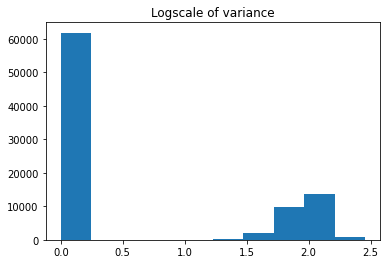

In [51]:
from matplotlib import pyplot as plt
all_variances = editors_variance.rdd.map(lambda x : x.variance + 1).collect()
plt.title('Logscale of variance')
plt.hist(np.log(all_variances))
plt.show()

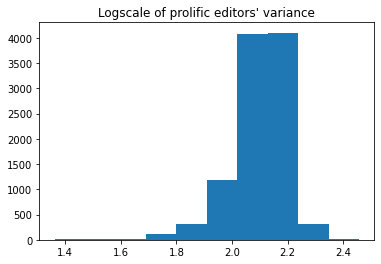

Average edit is 4.5872085802991815


In [69]:
# get number of edits for prolific editors (edit more than the average amount) and plot it
average_edit =  editors_variance.select(avg(size('counts'))).collect()[0][0]
prolific_editors = editors_variance.filter(size('counts') > average_edit)
prolific_variance = prolific_editors.rdd.map(lambda x : x.variance + 1).collect()
plt.title('Logscale of prolific editors\' variance')
plt.hist(np.log(prolific_variance))
plt.show()
print(f"Average edit is {average_edit}")

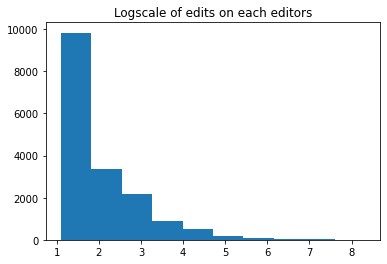

In [52]:
# Get number of edits for each editors and plot it
# using logscale since normal scale is way too tilted
from pyspark.sql.functions import size
editors_edit_counts = editors_variance.select(size('counts').alias('cnt')).rdd.map(lambda x : x.cnt).collect()
editors_edit_counts = [num for num in editors_edit_counts if num > 2]
plt.title('Logscale of edits on each editors')
plt.hist(np.log(editors_edit_counts))
plt.show()

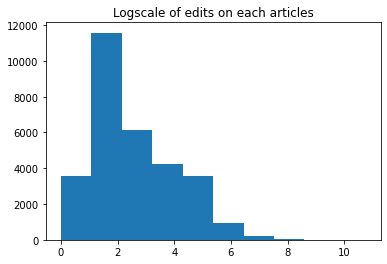

In [53]:
# get number of edits for each articles and plot it
article_edit_counts = spark_df.select(size('username').alias('cnt')).rdd.map(lambda x : x.cnt + 1).collect()
plt.title('Logscale of edits on each articles')
plt.hist(np.log(article_edit_counts))
plt.show()